In [68]:
import numpy as np
import time
from sklearn.linear_model._base import LinearModel, RegressorMixin
from sklearn.linear_model import LinearRegression, TheilSenRegressor
import matplotlib.pyplot as plt

# Reuse Example in Scikit-Learn Official Documentation

Let's first reuse an example from Scikit-Learn.
You can find it here:

https://scikit-learn.org/stable/auto_examples/linear_model/plot_theilsen.html

Our first step is to copy the data generation code:

In [70]:
np.random.seed(0)
n_samples = 200
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
w = 3.
c = 2.
noise = 0.1 * np.random.randn(n_samples)
y = w * x + c + noise
# 10% outliers
y[-20:] += -20 * x[-20:]
X = x[:, np.newaxis]

And, then copy the estimator comparison code. I removed RANSAC to make it clear.

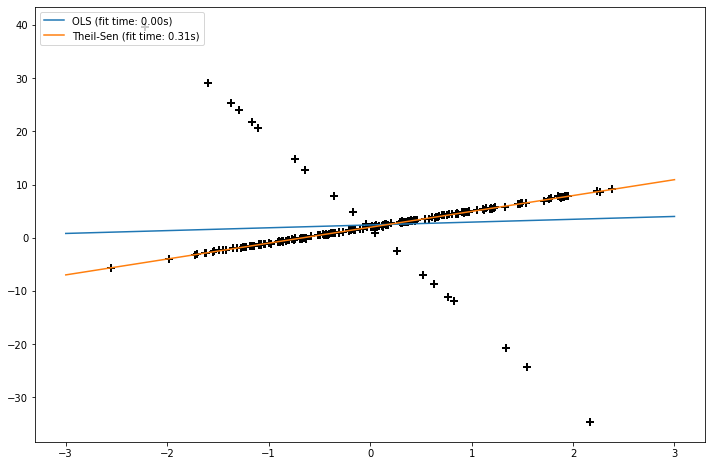

In [86]:
estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42))]

plt.figure(figsize=(12, 8))
plt.plot(x, y, 'k+', mew=2, ms=8)
line_x = np.array([-3, 3])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(line_x, y_pred,
             label='%s (fit time: %.2fs)' % (name, elapsed_time))

plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

# Create Our Own Theil Sen Regressor

In [72]:
class MyTheilSenRegressor(LinearModel, RegressorMixin):
    def __init__(self):
        ...
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # get the slop using for loops
        slops = []
        for i in range(n_samples):
            for j in range(i+1, n_samples):
                slop = (y[j] - y[i]) / (X[j][0] - X[i][0])
                slops.append(slop)
        final_slop = np.median(slops)
        x_bar = np.mean(X)
        y_bar = np.mean(y)
        intercept = y_bar - final_slop * x_bar
        self.intercept_ = intercept
        self.coef_ = np.array([final_slop])
        return self

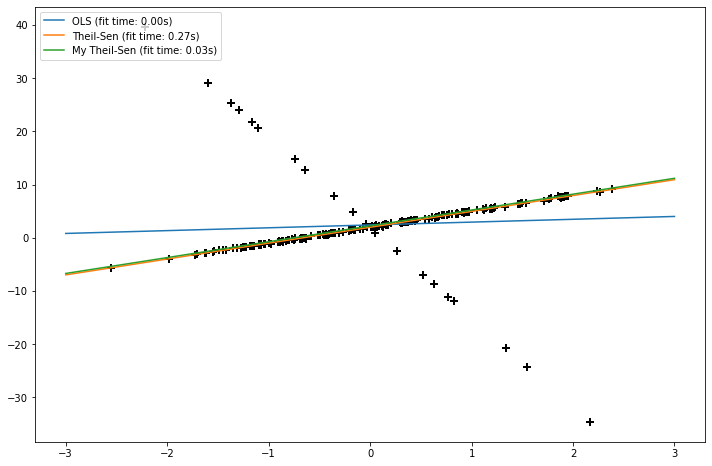

In [74]:
estimators = [('OLS', LinearRegression()),
                ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('My Theil-Sen', MyTheilSenRegressor()), ]
plt.figure(figsize=(12, 8))
plt.plot(x, y, 'k+', mew=2, ms=8)
line_x = np.array([-3, 3])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(line_x, y_pred,
             label='%s (fit time: %.2fs)' % (name, elapsed_time))

plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

# 30 Times Faster by numba

In [90]:
import numba


def get_slop(X, y):
    slops = []
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            slop = (y[j] - y[i]) / (X[j][0] - X[i][0])
            slops.append(slop)
    final_slop = np.median(slops)
    return final_slop

In [91]:
get_slop(X, y)

2.9812270237634264

In [92]:
%timeit get_slop(X, y)

27 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
@numba.njit()
def get_slops(X, y):
    slops = []
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            slop = (y[j] - y[i]) / (X[j][0] - X[i][0])
            slops.append(slop)
    #final_slop = np.median(slops)
    return slops

def get_slop2(X, y):
    slops = get_slops(X, y)
    return np.median(slops)

In [82]:
%timeit get_slop2(X, y)

949 µs ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [83]:
class FastTheilSenRegressor(LinearModel, RegressorMixin):
    def __init__(self):
        ...
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # get the slop using for loops
        final_slop = get_slop2(X, y)
        x_bar = np.mean(X)
        y_bar = np.mean(y)
        intercept = y_bar - final_slop * x_bar
        self.intercept_ = intercept
        self.coef_ = np.array([final_slop])
        return self

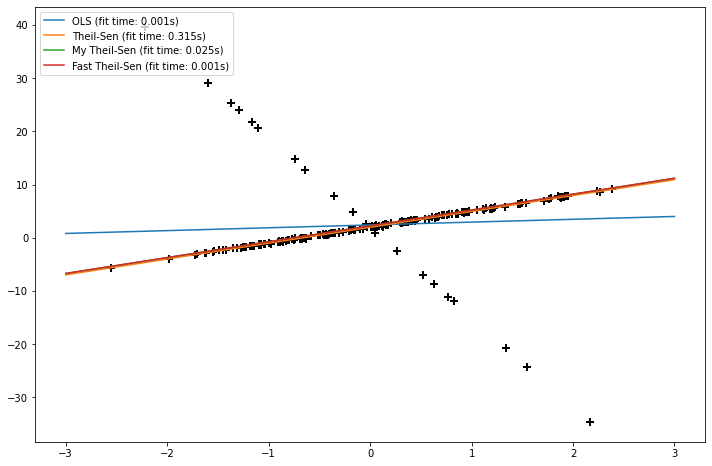

In [93]:
estimators = [('OLS', LinearRegression()),
                ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('My Theil-Sen', MyTheilSenRegressor()),
             ('Fast Theil-Sen', FastTheilSenRegressor())]
plt.figure(figsize=(12, 8))
plt.plot(x, y, 'k+', mew=2, ms=8)
line_x = np.array([-3, 3])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(line_x, y_pred,
             label='%s (fit time: %.3fs)' % (name, elapsed_time))

plt.axis('tight')
plt.legend(loc='upper left')
plt.show()